# MVP and HRP Portfolio Design for IT Sector Stocks


<a id='1'></a>
## 1. Loading the Data and Python Libraries

<a id='1.1'></a>
### 1.1. Loading the Python Libraries

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers


<a id='1.2'></a>
### 1.2. Loading the Data

In [2]:
# load dataset
dataset = read_csv('IT.csv',index_col=0)

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
## 2. Exploratory Data Analysis

In [5]:
# shape
dataset.shape

(1482, 10)

In [6]:
# peek at data
set_option('display.width', 100)
dataset.head()

INFY          TCS     HCLTECH       WIPRO       TECHM  LTI    MINDTREE  \
date                                                                                       
01-01-2016  552.625000  1208.199951  422.924988  208.668808  520.049988  NaN  720.775024   
04-01-2016  539.450012  1184.800049  422.975006  209.137558  516.400024  NaN  725.375000   
05-01-2016  537.025024  1174.474976  421.399994  208.837555  521.900024  NaN  735.650024   
06-01-2016  534.674988  1190.800049  420.700012  208.162552  525.099976  NaN  725.950012   
07-01-2016  525.400024  1185.625000  412.524994  206.193802  510.799988  NaN  708.674988   

               MPHASIS     COFORGE  LTTS  
date                                      
01-01-2016  496.350006  577.599976   NaN  
04-01-2016  497.299988  580.500000   NaN  
05-01-2016  491.649994  573.099976   NaN  
06-01-2016  477.750000  568.950012   NaN  
07-01-2016  458.399994  537.799988   NaN

<a id='3'></a>
## 3. Data Pre-processing

<a id='3.1'></a>
### 3.1. Data Cleaning
We check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [7]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = True


(1482, 10)

Getting rid of the columns with more than 30% missing values. 

In [9]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(1482, 10)

Given that there are null values drop the rown contianing the null values.

In [10]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head()

INFY          TCS     HCLTECH       WIPRO       TECHM  LTI    MINDTREE  \
date                                                                                       
01-01-2016  552.625000  1208.199951  422.924988  208.668808  520.049988  NaN  720.775024   
04-01-2016  539.450012  1184.800049  422.975006  209.137558  516.400024  NaN  725.375000   
05-01-2016  537.025024  1174.474976  421.399994  208.837555  521.900024  NaN  735.650024   
06-01-2016  534.674988  1190.800049  420.700012  208.162552  525.099976  NaN  725.950012   
07-01-2016  525.400024  1185.625000  412.524994  206.193802  510.799988  NaN  708.674988   

               MPHASIS     COFORGE  LTTS  
date                                      
01-01-2016  496.350006  577.599976   NaN  
04-01-2016  497.299988  580.500000   NaN  
05-01-2016  491.649994  573.099976   NaN  
06-01-2016  477.750000  568.950012   NaN  
07-01-2016  458.399994  537.799988   NaN

<a id='3.2'></a>
### 3.2. Training and Test Dataset Preparation

For the purpose of clustering, we will be using annual return figures. Let us prepare the dataset for training and testing, by separating 83.30% of the records for training the models and remaining records for testing. These figures have been chosen in such a way that the records of the year 2021 go into the test dataset while other records remain in the training dataset.

In [20]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8330)

In [21]:
X_train = X.head(train_len)

In [22]:
X_train

INFY          TCS     HCLTECH       WIPRO       TECHM          LTI  \
date                                                                                    
01-01-2016   552.625000  1208.199951  422.924988  208.668808  520.049988          NaN   
04-01-2016   539.450012  1184.800049  422.975006  209.137558  516.400024          NaN   
05-01-2016   537.025024  1174.474976  421.399994  208.837555  521.900024          NaN   
06-01-2016   534.674988  1190.800049  420.700012  208.162552  525.099976          NaN   
07-01-2016   525.400024  1185.625000  412.524994  206.193802  510.799988          NaN   
...                 ...          ...         ...         ...         ...          ...   
24-12-2020  1236.050049  2909.350098  919.349976  382.200012  947.250000  3625.600098   
28-12-2020  1240.300049  2929.399902  921.799988  382.899994  947.099976  3640.750000   
29-12-2020  1250.300049  2930.500000  935.900024  385.000000  965.650024  3609.949951   
30-12-2020  1246.800049  2909.300049  940.700012  384.399994  983.250000  3661.149902   
31-12-2020  1255.800049  2862.750000  946.150024  386.250000  973.200012  3659.500000   

               MINDTREE      MPHASIS      COFORGE         LTTS  
date                                                            
01-01-2016   720.775024   496.350006   577.599976          NaN  
04-01-2016   725.375000   497.299988   580.500000          NaN  
05-01-2016   735.650024   491.649994   573.099976          NaN  
06-01-2016   725.950012   477.750000   568.950012          NaN  
07-01-2016   708.674988   458.399994   537.799988          NaN  
...                 ...          ...          ...          ...  
24-12-2020  1597.699951  1554.550049  2652.550049  2348.649902  
28-12-2020  1608.800049  1560.550049  2690.899902  2389.000000  
29-12-2020  1621.750000  1559.199951  2680.500000  2371.100098  
30-12-2020  1629.949951  1590.400024  2694.600098  2338.649902  
31-12-2020  1660.349976  1539.949951  2705.149902  2339.600098  

[1234 rows x 10 columns]

In [23]:
X_test = X.tail(row-train_len)

In [24]:
#Calculate percentage return 
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms.

<a id='4'></a>
## 4. Evaluate the Models

<a id='4.1'></a>
### 4.1. Building Dendrogram for the HRP Model

The first step is to look for clusters of correlated stcoks using the agglomerate hierarchical clustering technique. The hierarchy class
has a dendrogram method which takes the value returned by the linkage method of
the same class.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

#### Correlation Computation

In [25]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [26]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([0.        , 2.        , 0.66750561, 2.        ])

Computation of linkages is followed by the visualization of the clusters through a dendrogram, which displays a cluster tree.
The leaves are the individual stocks and the root represents the final single cluster. The “distance” between each cluster is shown along the y-axis, and thus the longer the branches indicate less correlated clusters of stcoks.

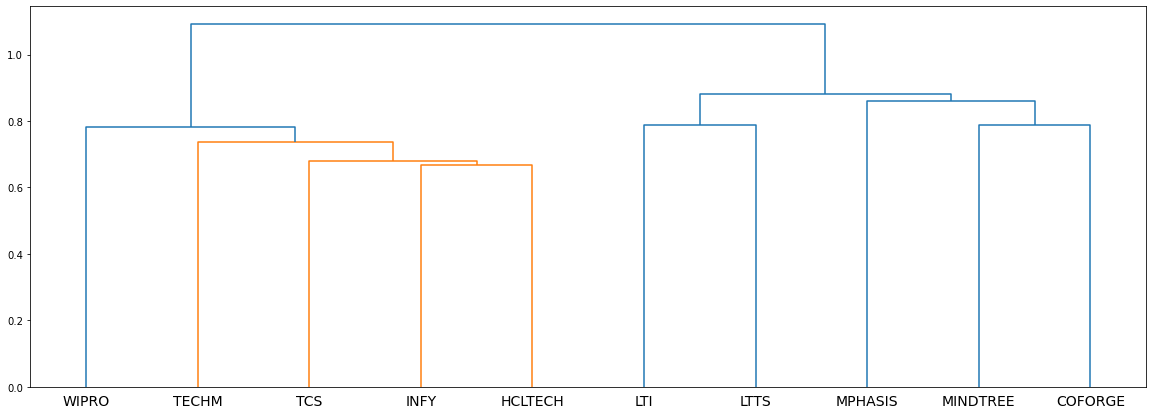

In [27]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
#plt.title("Dendrograms")
dendrogram(link,labels = X.columns, leaf_font_size=14)
plt.show()

<a id='4.2'></a>
### 4.2 Steps involved in the HRP Model Design 

#### Quasi-Diagonalization and Weights Computation for HRP


Quasi-diagonalization is a matrix seriation process used in hierarchical clustering. The process involves reorganizing the covariance matrix of returns in such a way that stocks with similar returns are placed together. This matrix diagonalization allows us to distribute weights optimally following an inverse-variance allocation. For more details refer to Chapter 4 of the book.

In [28]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Recursive Bisection

This step distributes the weights through recursive bisection based on the cluster covariance.

In [29]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

#### Comparison of HRP with MVP

So, in this step, python functions are defined for comparing the following two portfolio design approaches.

    1. MVP - Markowitz’s Minimum-Variance Portfolio
    2. HRP - Hierarchial Risk Parity

In [30]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Computation of the Weight Allocation for the Portfolios

In [31]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [32]:
portfolios = get_all_portfolios(returns)
print(portfolios)

               MVP       HRP
INFY      0.064376  0.116724
TCS       0.210146  0.140813
HCLTECH   0.057557  0.137049
WIPRO     0.257600  0.122418
TECHM     0.040101  0.088033
LTI       0.078048  0.068379
MINDTREE  0.028572  0.092336
MPHASIS   0.149326  0.111033
COFORGE   0.001522  0.066227
LTTS      0.112752  0.056987


Text(0.5, 1.0, 'HRP')

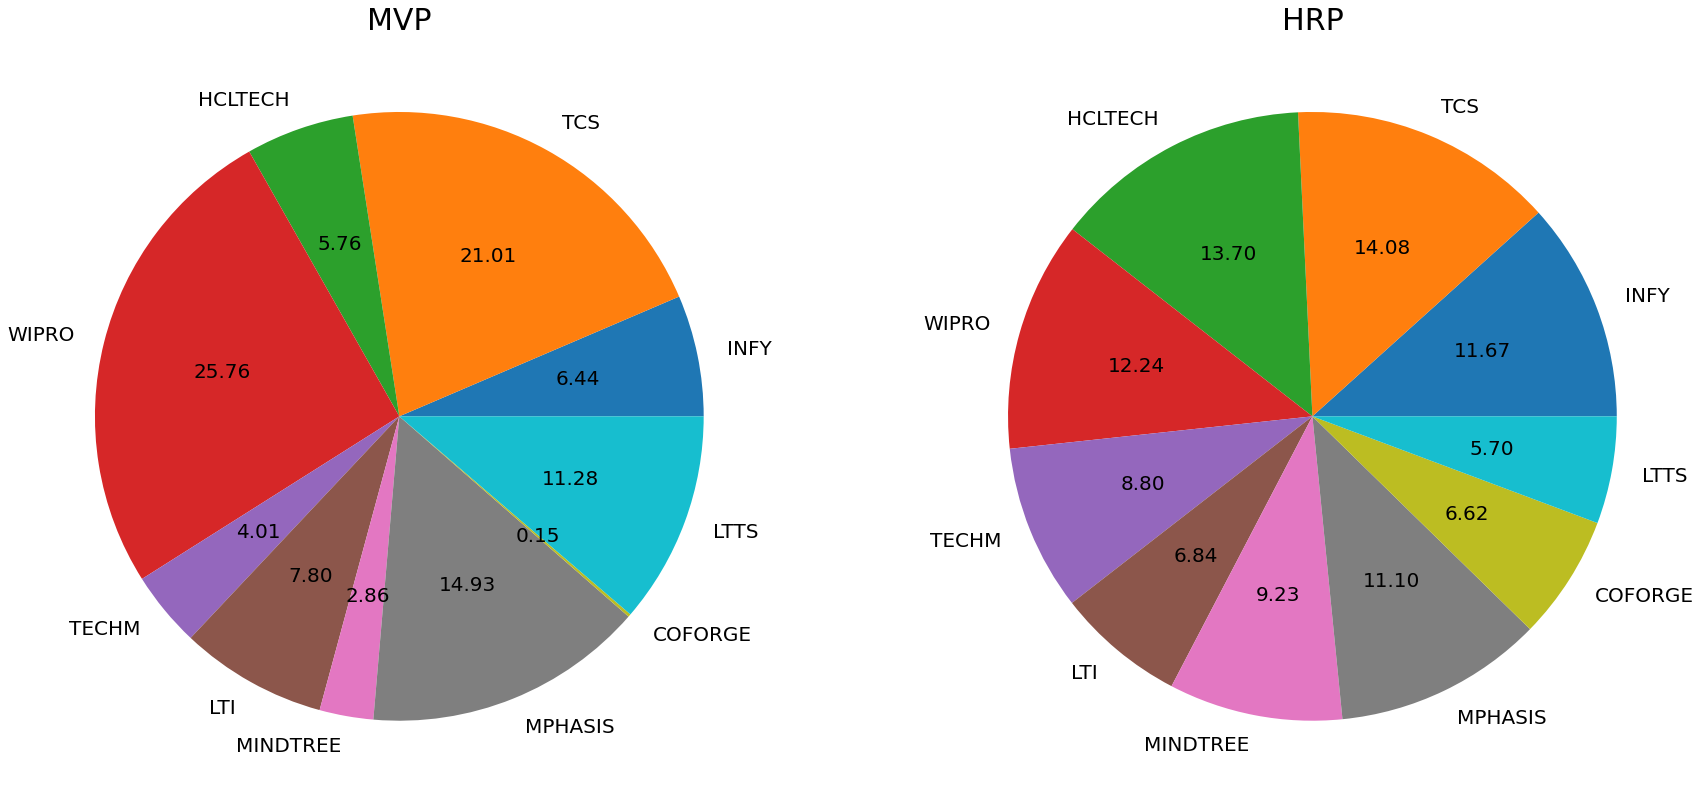

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], labels= portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1], labels=portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

In [34]:
# MVP - Markowitz’s Minimum-Variance Portfolio Weights
portfolios.iloc[:,0]

INFY        0.064376
TCS         0.210146
HCLTECH     0.057557
WIPRO       0.257600
TECHM       0.040101
LTI         0.078048
MINDTREE    0.028572
MPHASIS     0.149326
COFORGE     0.001522
LTTS        0.112752
Name: MVP, dtype: float64

In [35]:
# HRP - Hierarchial Risk Parity Portfolio Weights
portfolios.iloc[:,1]

INFY        0.116724
TCS         0.140813
HCLTECH     0.137049
WIPRO       0.122418
TECHM       0.088033
LTI         0.068379
MINDTREE    0.092336
MPHASIS     0.111033
COFORGE     0.066227
LTTS        0.056987
Name: HRP, dtype: float64

<a id='5'></a>
## 5. Performance Evaluation of the Portfolios 

### 5.1 Cumulative Returns - Training and Test Data 

In [36]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<AxesSubplot:xlabel='date', ylabel='Return'>

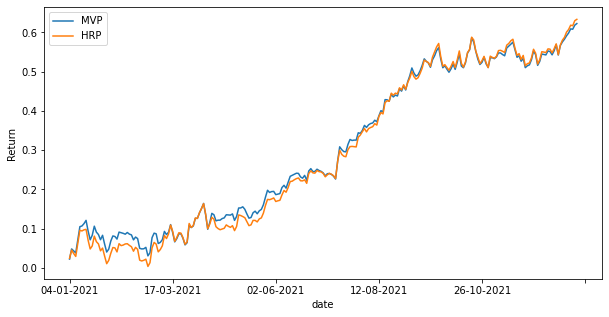

In [37]:
Insample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")

In [38]:
ret_insample=Insample_Result.mean() * 252
ret_insample

MVP    0.275127
HRP    0.296455
dtype: float64

In [39]:
ret_out_of_sample = OutOfSample_Result.mean() * 252
ret_out_of_sample

MVP    0.634865
HRP    0.645831
dtype: float64

###  5.2 Sharpe Ratio and Annual Volatility - Training and Test Data

In [40]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

stdev  sharp_ratio
MVP  0.195641     1.406281
HRP  0.206351     1.436652

In [41]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

stdev_oos  sharp_ratio_oos
MVP   0.220823         2.874994
HRP   0.224095         2.881949